In [2]:
import matplotlib.pyplot as plt
import mplhep as hep
hep.style.use("ATLAS")
import os
import numpy as np
from matplotlib.ticker import MultipleLocator

import utils as ut

2025-08-06 16:46:36.251111: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-06 16:46:36.301944: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-06 16:46:36.302667: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-06 16:46:39.208607: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# function to perform analysis of efficiency results
def analyzeResults(pt, pt_bins, results):
    effs, eff_errs = [], []
    # loop over the pT bins
    for i in range(len(pt_bins) - 1):
        in_bin_extracted = (pt >= pt_bins[i]) & (pt < pt_bins[i+1])
        N = np.sum(in_bin_extracted)
        if np.sum(in_bin_extracted) > 0:
            # Check how many were correctly labeled as high pT (label 0)
            labeled_high_pt = (results[in_bin_extracted] == 0)
            npass = np.sum(labeled_high_pt)
            eff = npass / N
            eff_err = efficiency_error(eff, N)
            # save
            effs.append(eff)
            eff_errs.append(eff_err)
        else:
            effs.append(0)
            eff_errs.append(0)
    return np.array(effs), np.array(eff_errs)
    
# efficiency error calculation
def efficiency_error(eff, N):
    ''' 
    See section 2.2.1 https://lss.fnal.gov/archive/test-tm/2000/fermilab-tm-2286-cd.pdf
    eff = estimate of the efficiency
    N = sample size
    '''
    return np.sqrt(eff * (1 - eff) / N)

In [9]:
dir = "/asic/projects/C/CMS_PIX_28/abadea/working/filter/test/tmp/400_1600_2400"

# load the final results
pt = np.load(os.path.join(dir, "pts.npy"))
ylocals = np.load(os.path.join(dir, "ylocals.npy"))
clslabels = np.load(os.path.join(dir, "clslabels.npy"))
keras_predictions = np.load(os.path.join(dir, "keras_predictions.npy"))
keras_predictions = np.argmax(keras_predictions, axis=1)
qkeras_predictions = np.load(os.path.join(dir, "qkeras_predictions.npy"))
qkeras_predictions = np.argmax(qkeras_predictions, axis=1)

# get just the ylocal we want
bin_width = (8.1 - (-8.1))/12 # 12 bins from -8.1 to 8.1, as chosen in Jiuen's paper
bin_number = 0 # Giuseppe seems to have chosen the 0th bin to produce the test-vectors from dataset 8 (https://github.com/GiuseppeDiGuglielmo/directional-pixel-detectors/blob/asic-flow/multiclassifier/train.ipynb)
ylocal_min = -8.1 + bin_number* bin_width
ylocal_max = ylocal_min + bin_width
interested_range = (ylocal_min, ylocal_max) # the range of y-local values we are interested in passing to the NN
mask = (ylocals >= interested_range[0]) & (ylocals < interested_range[1])
print(mask.sum())
# apply the mask
pt = pt[mask]
clslabels = clslabels[mask]
keras_predictions = keras_predictions[mask]
qkeras_predictions = qkeras_predictions[mask]

# Create bins for true pT values from -4 to 4
bins_pos = np.unique(np.concatenate([
    np.linspace(0, 1, 5, endpoint=False),
    np.linspace(1, 2, 5, endpoint=False),
    np.linspace(2, 4, 3, endpoint=True)
]))
bins_neg = -1 * bins_pos[::-1]
pt_bins = np.unique(np.concatenate([bins_neg, bins_pos]))
bin_centers = (pt_bins[:-1] + pt_bins[1:]) / 2
bin_widths = np.diff(pt_bins)

# asic results
true_res = analyzeResults(pt, pt_bins, clslabels)
keras_res = analyzeResults(pt, pt_bins, keras_predictions)
qkeras_res = analyzeResults(pt, pt_bins, qkeras_predictions)

299633


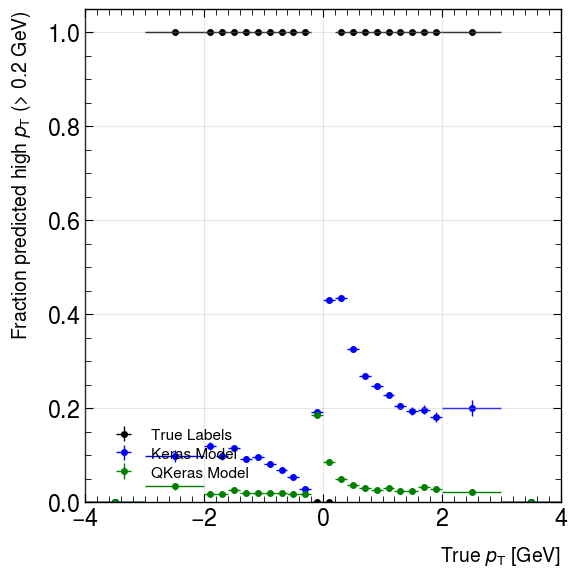

In [6]:
# Create the plot
fig, ax = plt.subplots(figsize=(6,6))

# plot error bars
ax.errorbar(bin_centers, true_res[0], xerr=bin_widths/2, yerr=true_res[1], fmt='o', linewidth=1, markersize=4, color="black", label="True Labels")
ax.errorbar(bin_centers, keras_res[0], xerr=bin_widths/2, yerr=keras_res[1], fmt='o', linewidth=1, markersize=4, color="blue", label="Keras Model")
ax.errorbar(bin_centers, qkeras_res[0], xerr=bin_widths/2, yerr=qkeras_res[1], fmt='o', linewidth=1, markersize=4, color="green", label="QKeras Model")

# set plot styles
ax.set_xlabel(r'True $p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'Fraction predicted high $p_{\mathrm{T}}$ (> 0.2 GeV)')
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1.05)
ax.set_xlim(-4, 4)
ax.tick_params(which='minor', length=4)
ax.tick_params(which='major', length=6)
ax.xaxis.set_minor_locator(MultipleLocator(0.2))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))

ax.legend(loc='lower left', fontsize=11, bbox_to_anchor=(0, 0))
plt.tight_layout()
# plt.savefig('high_pt_fraction_vs_true_pt.pdf', dpi=300, bbox_inches='tight')